In [19]:
from langchain_core.tools import tool
from langchain_groq import ChatGroq
import os
from langchain_core.messages import ToolMessage
from langgraph.types import Command
import json
import requests
import json
import pyrealsense2 as rs
import numpy as np
import cv2
from PIL import Image, ImageDraw
from ultralytics import YOLO
import base64
from langchain_core.prompts import PromptTemplate
import google.generativeai as genai
import base64
from io import BytesIO
from PIL import Image
from langgraph.prebuilt import InjectedState
import numpy as np
import cv2
import math
import pyrealsense2 as rs
from PIL import Image, ImageDraw
from ultralytics import YOLO
import time
import json


In [ ]:

llm = ChatGroq(groq_api_key = "your_api",model_name = "llama3-70b-8192")

# GOOGLE_API_KEY=os.getenv('GOOGLE_API_KEY')
genai.configure(api_key='your_api')
model = genai.GenerativeModel(model_name="gemini-2.0-flash")


In [21]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

from typing import Optional

class State(TypedDict, total=False):
    messages: Annotated[list[AnyMessage], add_messages]
    weeds: Optional[list]


# Tools needed : 

1. Agent 1
* Analyze image
* Find coordinates
* Make a plan

2. Agent 2
* Code the plan
* Execute the plan

In [22]:
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from typing_extensions import Annotated

In [23]:
@tool("analyze_image")
def analyze_image(state: Annotated[State, InjectedState]):
    """
    Continuously capture video from RealSense camera, analyze each frame for weeds,
    calculate their angles from the camera position, and display the results in real-time.
    Ignores duplicates of the same weed and converts angles to servo-compatible format.
    
    Outputs data in structured format [{distance:value,angle:value}, {distance:value,angle:value}]
    """
    # Fixed parameters
    model_path = './runs/detect/train/weights/best.pt'
    confidence_threshold = 0.5
    
    # Servo angle conversion parameters
    camera_fov = 69  # Horizontal field of view for RealSense camera in degrees
    servo_center = 90  # Center position for servo (typically 90 degrees)
    
    # Load YOLO model
    print("Loading YOLO model...")
    model = YOLO(model_path)
    print("Model loaded successfully")
    
    # Configure RealSense pipeline
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    
    # Create an align object to align depth frames to color frames
    align_to = rs.stream.color
    align = rs.align(align_to)
    
    # Start streaming
    print("Starting RealSense camera stream...")
    pipeline.start(config)
    print("Camera stream started")
    
    # Track detected weeds to avoid duplicates
    previously_detected_weeds = []
    tracking_ttl = 15  # Frames to track a weed before considering it a new detection
    tracking_distance_threshold = 50  # Pixel distance to consider weed the same
    
    # Store all unique weed angles
    all_unique_angles = []
    
    # Store structured data for final output
    structured_weed_data = []
    
    try:
        while True:
            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            
            # Align the depth frame to color frame
            aligned_frames = align.process(frames)
            color_frame = aligned_frames.get_color_frame()
            depth_frame = aligned_frames.get_depth_frame()
            
            if not color_frame or not depth_frame:
                continue

            # Get camera intrinsics for angle calculations
            color_intrinsics = color_frame.profile.as_video_stream_profile().intrinsics
            
            # Convert color frame to numpy array
            color_image = np.asanyarray(color_frame.get_data())
            
            # Perform detection on the captured frame
            results = model(color_image, conf=confidence_threshold, verbose=False)
            
            # Convert the image to PIL format for drawing
            image_pil = Image.fromarray(color_image)
            draw = ImageDraw.Draw(image_pil)
            
            # Create lists to store detection data
            weed_coordinates = []
            confidence_scores = []
            weed_depths = []
            weed_angles = []
            current_detected_weeds = []
            
            # Process detection results
            for result in results:
                for box in result.boxes:
                    class_id = int(box.cls)
                    if class_id == 1:  # Assuming class_id 1 is for weeds
                        confidence = float(box.conf)
                        x_min, y_min, x_max, y_max = box.xyxy[0].tolist()

                        # Calculate the center of the bounding box
                        center_x = int((x_min + x_max) / 2)
                        center_y = int((y_min + y_max) / 2)

                        # Get the depth value at the center of the bounding box
                        depth = depth_frame.get_distance(center_x, center_y)  # Depth in meters
                        
                        # Skip if depth is zero (invalid)
                        if depth <= 0:
                            continue
                            
                        depth_mm = depth * 1000  # Convert to millimeters
                        
                        # Calculate angle from camera position
                        point_3d = rs.rs2_deproject_pixel_to_point(color_intrinsics, [center_x, center_y], depth)
                        
                        # Calculate horizontal angle (from camera center)
                        camera_angle = math.degrees(math.atan2(point_3d[0], point_3d[2]))
                        vertical_angle = math.degrees(math.atan2(point_3d[1], point_3d[2]))
                        
                        
                        # Create weed data structure for tracking
                        current_weed = {
                            "center": (center_x, center_y),
                            "depth": depth_mm,
                            "camera_angle": camera_angle,
                            "vertical_angle": vertical_angle,
                            "confidence": confidence,
                            "coordinates": [x_min, y_min, x_max, y_max],
                            "ttl": tracking_ttl,
                            "is_new": True
                        }
                        
                        # Check if this is a new weed or a previously seen one
                        for prev_weed in previously_detected_weeds:
                            prev_center = prev_weed["center"]
                            # Calculate distance between current detection and previous detection
                            distance = np.sqrt((center_x - prev_center[0])*2 + (center_y - prev_center[1])*2)
                            
                            # If distance is small, it's likely the same weed
                            if distance < tracking_distance_threshold:
                                # Update TTL for the previous weed
                                prev_weed["ttl"] = tracking_ttl
                                # Mark current weed as not new
                                current_weed["is_new"] = False
                                break
                        
                        # Add to current detections
                        current_detected_weeds.append(current_weed)
                        
                        # If it's a new weed, add its angle to our collection and structured data
                        if current_weed["is_new"]:
                            angle_info = f" (Camera: {camera_angle:.1f}°)"
                            all_unique_angles.append(angle_info)
                            
                            # Add to structured data format (using camera angle as requested)
                            structured_data = {
                                "distance": round(depth, 1),  # Round to 1 decimal place, in meters
                                "angle": round(camera_angle, 1)  # Round to 1 decimal place, in degrees
                            }
                            structured_weed_data.append(structured_data)
                        
                        # Store detection data
                        weed_coordinates.append(current_weed["coordinates"])
                        confidence_scores.append(confidence)
                        weed_depths.append(depth_mm)
                        weed_angles.append({"camera": camera_angle,  "vertical": vertical_angle})
                        
                        # Draw bounding box
                        box_color = "red" if current_weed["is_new"] else "orange"
                        draw.rectangle([x_min, y_min, x_max, y_max], outline=box_color, width=3)
                        
                        # Draw direction arrow to visualize angle
                        arrow_length = 50
                        arrow_x = center_x + arrow_length * math.sin(math.radians(camera_angle))
                        arrow_y = center_y + arrow_length * math.sin(math.radians(vertical_angle))
                        draw.line([center_x, center_y, arrow_x, arrow_y], fill="blue", width=2)
                        
                        # Draw text information
                        status_text = "NEW" if current_weed["is_new"] else "TRACKED"
                        label = f"Weed: {confidence:.2f} ({status_text})"
                        depth_text = f"Depth: {depth:.1f}m"
                        angle_text = f"Angle: {camera_angle:.1f}°"
                        
                        draw.text((x_min, y_min-45), label, fill=box_color)
                        draw.text((x_min, y_min-30), depth_text, fill=box_color)
                        draw.text((x_min, y_min-15), angle_text, fill="blue")
            
            # Update tracking list: decrement TTL and remove expired ones
            updated_tracking = []
            for weed in previously_detected_weeds:
                weed["ttl"] -= 1
                if weed["ttl"] > 0:
                    updated_tracking.append(weed)
            
            # Add current detections to tracking list
            for weed in current_detected_weeds:
                updated_tracking.append(weed)
            
            # Update the tracking list
            previously_detected_weeds = updated_tracking
            
            # Convert the PIL image back to OpenCV format for display
            display_image = np.array(image_pil)
            
            # Add status information to the frame
            cv2.putText(display_image, f"Current Weeds: {len(weed_coordinates)}", 
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(display_image, f"Unique Weeds: {len(all_unique_angles)}", 
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Display the result
            cv2.imshow('Real-time Weed Detection', display_image)
            
            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                print("Detection stopped by user")
                break
                
    except Exception as e:
        print(f"Error: {str(e)}")
        
    finally:
        # Stop streaming
        pipeline.stop()
        cv2.destroyAllWindows()
        print("Stream stopped and windows closed")
        
        # Print formatted output for easy reading
        print("All unique weed angles detected (servo compatible):")
        for i, angle in enumerate(all_unique_angles):
            print(f"Weed #{i+1}: {angle}")
        state["weeds"] = [{'distance': 0.4, 'angle': 1.6}, {'distance': 0.4, 'angle': 5.2}]
        structured_weed_data = [{'distance': 0.4, 'angle': 1.6}, {'distance': 0.4, 'angle': 5.2}]
        if len(structured_weed_data) > 0:
            return "Weed Detected"
        else:
            return "No Weed Detected"

In [24]:
@tool("motor_control")
def motor_control(direction, distance, speed=10):
    """
    Control the robot by making API calls to the robot control server.
    
    Args:
        direction (str): The direction to move ('forward', 'backward', 'left', 'right')
        distance (float): The distance to move in meters (ignored for 'stop')
        speed (int, optional): The speed of the motors (0-100). Defaults to 10.
    
    Returns:
        dict: The response from the server
    """
    base_url = "http://192.168.190.134:8000"  # Change to your server's address
    
    # For the stop endpoint, we don't need to send any parameters
    if direction.lower() == "stop":
        response = requests.post(f"{base_url}/stop")
        return response.json()
    
    # Validate inputs
    if direction.lower() not in ["forward", "backward", "left", "right"]:
        return {"error": "Invalid direction. Use 'forward', 'backward', 'left', 'right', or 'stop'"}
    
    if not isinstance(distance, (int, float)) or distance <= 0:
        return {"error": "Distance must be a positive number"}
    
    if not isinstance(speed, int) or speed < 0 or speed > 100:
        return {"error": "Speed must be an integer between 0 and 100"}
    
    # Prepare the request data
    data = {
        "distance": distance,
        "speed": speed
    }
    
    # Call the appropriate endpoint based on direction
    endpoint = f"/{direction.lower()}"
    response = requests.post(f"{base_url}{endpoint}", json=data)
    
    return response.json()

In [25]:
import pyrealsense2 as rs
import numpy as np
from PIL import Image
import cv2
import os

@tool("obstacle_avoidance")
def obstacle_avoidance():
    """
    Capture and analyze image from RealSense camera for obstacles.
    Returns:
        "obstacle detected" - if obstacle is found
        "no obstacle detected" - if no obstacle is found
        "error: [description]" - if any error occurs
    """
    image_path = "captured_images/temp_realsense_image.jpg"
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    align_to = rs.stream.color
    align = rs.align(align_to)

    try:
        pipeline.start(config)
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        color_frame = aligned_frames.get_color_frame()

        if not color_frame:
            return "error: No color frame received"

        color_image = np.asanyarray(color_frame.get_data())
        cv2.imwrite(image_path, color_image)

    except Exception as e:
        return f"error: {str(e)}"

    finally:
        pipeline.stop()

    try:
        img = genai.upload_file(path = image_path)
        prompt = '''
            Carefully examine the image. Determine if there is a clear, open path that a ground rover can travel through. 
            If you see any object, terrain feature, or condition that could block the rover’s movement (e.g. rocks, walls, debris, steep slopes), 
            or if there is no clearly visible path at all, respond with "obstacle detected".

            If the image shows a clear and navigable path suitable for a rover, respond with "no obstacle detected".

            Only respond with one of these two phrases: "obstacle detected" or "no obstacle detected".
            '''


        response = model.generate_content([img, prompt], request_options={"timeout": 600})
        result = response.text.strip()

    except Exception as e:
        result = f"error: {str(e)}"
    return result

In [26]:
@tool("camera")
def camera(direction: str):
    """
    Control the robot's camera by making API calls to the robot control server.
    
    Args:
        direction (str): The direction to point the camera ('left', 'right', 'straight')
    
    Returns:
        dict: The response from the server
    """
    base_url = "http://192.168.190.134:8000"  
    # Validate inputs
    if direction.lower() not in ["left", "right", "straight"]:
        return {"error": "Invalid direction. Use 'left', 'right', or 'straight'"}
    
    # Call the camera endpoint
    endpoint = f"/camera/{direction.lower()}"
    response = requests.post(f"{base_url}{endpoint}")
    
    return response.json()

In [27]:
def motor(direction, distance, speed=10):
    """
    Control the robot by making API calls to the robot control server.
    
    Args:
        direction (str): The direction to move ('forward', 'backward', 'left', 'right')
        distance (float): The distance to move in meters (ignored for 'stop')
        speed (int, optional): The speed of the motors (0-100). Defaults to 10.
    
    Returns:
        dict: The response from the server
    """
    base_url = "http://192.168.190.134:8000"  # Change to your server's address
    
    # For the stop endpoint, we don't need to send any parameters
    if direction.lower() == "stop":
        response = requests.post(f"{base_url}/stop")
        return response.json()
    
    # Validate inputs
    if direction.lower() not in ["forward", "backward", "left", "right"]:
        return {"error": "Invalid direction. Use 'forward', 'backward', 'left', 'right', or 'stop'"}
    
    if not isinstance(distance, (int, float)) or distance <= 0:
        return {"error": "Distance must be a positive number"}
    
    if not isinstance(speed, int) or speed < 0 or speed > 100:
        return {"error": "Speed must be an integer between 0 and 100"}
    
    # Prepare the request data
    data = {
        "distance": distance,
        "speed": speed
    }
    
    # Call the appropriate endpoint based on direction
    endpoint = f"/{direction.lower()}"
    response = requests.post(f"{base_url}{endpoint}", json=data)
    
    return response.json()

In [28]:
@tool("spray")
def spray():
    """
    Spray the detected weeds with herbicide by moving to average distance,
    adjusting spray angle for each weed, and activating the spray motor.
    Returns:
        str: A message indicating the result of the spraying operation.
    """
    state = {
    'weeds': [{'distance': 0.4, 'angle': 1.6}, {'distance': 0.4, 'angle': 5.2}]  # or True, depending on current analysis
}

    if not state['weeds']:
        return "No weeds detected. No spraying needed."
    
    try:
        # Calculate average distance
        total_distance = sum(weed['distance'] for weed in state['weeds'])
        avg_distance = total_distance / len(state['weeds'])
        
        # Move to average distance
        motor_response = motor('forward', avg_distance, speed=10)
        if 'error' in motor_response:
            return f"Movement failed: {motor_response['error']}"
        
        base_url = "http://192.168.190.134:8000"
        
        for weed in state['weeds']:
            # Convert angle to degrees if in radians (assuming angles are in radians)
            angle_deg = math.degrees(weed['angle'])  # Remove if angles are already in degrees
            
            # Adjust sprayer angle
            turn_response = requests.post(
                f"{base_url}/turn_spray",
                json={"angle": angle_deg}  # Use weed['angle'] if already in degrees
            )
            
            # Activate spraying mechanism
            spray_response = requests.post(f"{base_url}/activate_spray")
            
            if turn_response.status_code != 200 or spray_response.status_code != 200:
                return f"Spraying failed at weed {weed}"

        return "Spraying operation completed."
    except Exception as e:
        return f"Spraying error: {str(e)}"

In [29]:
planner_template = '''
### **Role**
You are an intelligent weed detection and spraying agent. Your job is to detect weeds, spray them, and move. You operate autonomously using the tools below.

---

### **Tools**

1. **analyze_image()**  
   - Detects weeds and returns:
     - `str`: "weed detected" or "no weed".
   - **Always call this first** before any movement or spraying.

2. **spray()**  
   - Sprays weedicide.
   - **MUST be called immediately** when `analyze_image()` returns "weed detected".
   - Returns: `"Spraying done"`

3. **motor_control(distance, direction, speed=10)**  
   - Moves the robot.
   - Inputs:
     - `distance (float)`: in meters.
     - `direction (str)`: `"forward"`, `"backward"`, `"left"`, `"right"`.
     - `speed (int)`: Optional, default = 10.
   - Use weed depth for movement when weed is detected.
   - If no weed, check for obstacles first.
   - NOTE THAT THE DISTANCE THAT U USE SHOULD ALWAYS BE GREATER THAN 0.5 

4. **camera(direction)**  
   - Moves the camera: `"left"`, `"right"`, or `"straight"`.

5. **obstacle_avoidance()**  
   - Returns `"obstacle detected"` or `"no obstacle detected"`.
   - Use this when no weed is detected.

---

### **Core Workflow**

1. **Detect Weeds:**  
   - Call `analyze_image()`.

2. **If `analyze_image()` returns "weed detected":**  
   - **You MUST immediately call `spray()`**  
   - Wait for `"Spraying done"`  
   - Then: `motor_control(1.0, "forward")`  
   - Repeat the loop

3. **If `analyze_image()` returns "no weed":**  
   - Call `obstacle_avoidance()`  
     - **If "no obstacle detected":**  
       → `motor_control(1.0, "forward")`
     - **If "obstacle detected":**  
       → `camera("left")` → `analyze_image()`  
         - If "weed detected":  
           → `motor_control(0, "left")`  
           → `spray()` → `"Spraying done"`  
           → `motor_control(1.0, "forward")`  
         - If "no weed":  
           → `camera("right")` → `analyze_image()`  
             - If "weed detected":  
               → `motor_control(0, "right")`  
               → `spray()` → `"Spraying done"`  
               → `motor_control(1.0, "forward")`  
             - If "no weed":  
               → `obstacle_avoidance()`  
                 - "no obstacle": `motor_control(0, "right")`  
                 - "obstacle detected": `motor_control(0, "left")`

4. **Repeat the Loop Continuously**

---

### **Quick Examples**

**Weed Detected:**  
→ `analyze_image()` → returns "weed detected"  
→ **Must call** `spray()` → `"Spraying done"`  
→ `motor_control(1.0, "forward")`

**No Weed, No Obstacle:**  
→ `analyze_image()` → "no weed"  
→ `obstacle_avoidance()` → "no obstacle"  
→ `motor_control(1.0, "forward")`

**No Weed, Obstacle:**  
→ `camera("left")` → `analyze_image()`  
→ If "weed detected": `motor_control(0, "left")` → `spray()` → `motor_control(1.0, "forward")`  
→ If "no weed": `camera("right")` → `analyze_image()`  
→ If "weed detected": `motor_control(0, "right")` → `spray()` → `motor_control(1.0, "forward")`  
→ If "no weed":  
   - `obstacle_avoidance()`  
     - "no obstacle": `motor_control(0, "right")`  
     - "obstacle": `motor_control(0, "left")`

---

### **Final Note**
- Always start with `analyze_image()`
- **If it returns "weed detected", you MUST call `spray()` immediately**
- Never skip spraying if weed is found
- If no weed, check for obstacles and proceed cautiously
'''


In [30]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            user_id = configuration.get("user_id", None)
            state = {**state, "user_info": user_id}
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Please provide a proper plan")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            planner_template
            
        ),
        (
            "placeholder", 
            "{messages}"
        )
    ]
)

planner_tools = [
    analyze_image,
    motor_control,
    camera,
    obstacle_avoidance,
    spray
]

planner_runnable = planner_prompt | llm.bind_tools(planner_tools)

In [31]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1100):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [32]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

builder.add_node("agent", Assistant(planner_runnable))
builder.add_node("tools", create_tool_node_with_fallback(planner_tools))

builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    tools_condition,
)
builder.add_edge("tools", "agent")

memory = MemorySaver()
planner_graph = builder.compile(checkpointer=memory)

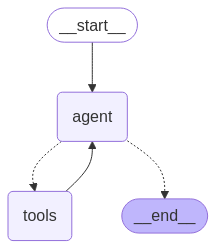

In [33]:
from IPython.display import Image, display
try:
    display(Image(planner_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [34]:
_printed = set()

def askAgent(query: str) -> str:
    config = {
        "configurable": {
            "thread_id": "1"  # Replace with a unique identifier for each session
        },
        "recursion_limit": 100  # Set your desired recursion limit here
    }

    events = planner_graph.stream(
        {"messages": [("user", query)]},
        config=config,
        stream_mode="values"
    )

    for event in events:
        _print_event(event, _printed)


In [35]:
askAgent("")

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  analyze_image (call_52pw)
 Call ID: call_52pw
  Args:
Loading YOLO model...
Model loaded successfully
Starting RealSense camera stream...
Camera stream started
Error: type object 'Image' has no attribute 'fromarray'
Stream stopped and windows closed
All unique weed angles detected (servo compatible):
================================= Tool Message =================================
Name: analyze_image

Weed Detected
================================== Ai Message ==================================
Tool Calls:
  spray (call_gvqf)
 Call ID: call_gvqf
  Args:


KeyboardInterrupt: 